# Recunoașterea Cifrelor Scrise de Mână

### Setul de date MNIST

MNIST este un set de date compus din diverse imagini cu cifrele de la 0 la 9 scrise de mână. Această aplicație a rețelelor neurale este una extrem de populară în mediul academic și orice tentativă (auto)didactică implicând rețelele neurale. Motivul pentru aceasta este dat de faptul că avem un singur canal de culoare pentru imaginile ce compun MNIST (aceste imagini sunt alb-negru). Această proprietate ne simplifică destul de mult munca. Setul de date are și un număr rezonabil de exemple, atât pentru antrenare cât și de test. Prin urmare putem să facem antrenarea chiar și pe CPU, chit că durează mai mult.

Putem lua setul acesta de date de aici: http://yann.lecun.com/exdb/mnist.

Noi vom lucra cu setul de date simplificat, ce se găsește aici:
- training set:
    - 60,000 de exemple etichetate (labelled) pe care le vom folosi ca să ne antrenăm rețeaua:
    https://pjreddie.com/media/files/mnist_train.csv
    
- test set:
    - 10,000 de samples în setul pe care-l folosim pentru efectuarea de teste asupra rețelei, pentru a vedea cum evoluează ea și cum se îmbunătățesc rezultatele pe date pe care rețeaua nu le-a văzut în faza de antrenare.
    https://pjreddie.com/media/files/mnist_test.csv
    
Structura celor două csv-uri (comma separated values) este, după cum urmează:
- label: cifre de la 0 la 9 ---> cifra ce se regăsește în imagine de fapt.
- valorile pixelilor din imagine. Vectorul de pixeli este 2D și are dimensiunile 28x28. Deci în csv vom observa 784 de valori după etichetă.

### 1. Prelucrarea Datelor
    1.1. Deschidem fișierele csv ce conțin datele și citim conținutul acestora apoi le închidem.
    1.2. Folosim virgula ca separator și obținem un vector de elemente din fiecare linie citită. Convertim vectorul de 784 valori de pixeli într-o matrice 28x28. Apoi afișăm imaginea pentru a ne face o idee vizuală despre setul de date.
    1.3. Transformăm valorile pixelilor din intervalul [0, 255] în [0, 1]. 
         Cum facem asta?
       - împărțirea la 255 a output-urilor raw din intervalul [0, 255]. 
         => Astfel le aducem în intervalul [0, 1]. 
    1.4. Pe prima poziție din csv avem clasa căreia aparține elementul corect (ce imagine afișează acesta). 
         Vrem să avem un vector de probabilități, mai degrabă decât un singur număr. Astfel alegem un vector de 10 elemente ca și target (cel cu care vom compara output-ul rețelei). Vom avea 1 pe poziția corespunzătoare cifrei din imagine (label-ului) și 0 pe restul pozițiilor.

In [38]:
import numpy as np
import matplotlib.pyplot as plot
import scipy.special
import scipy.ndimage
%matplotlib inline

!ls mnist_train.csv || wget https://pjreddie.com/media/files/mnist_train.csv
!ls mnist_test.csv || wget https://pjreddie.com/media/files/mnist_test.csv

mnist_train.csv
mnist_test.csv


Total samples: 60000


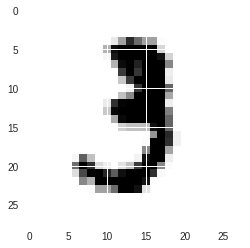

In [39]:
# 1.1. Read the data

# i) Open the csv file containing the data
train_data_file = open("mnist_train.csv", "r")
# ii) Read all the contents of the file as a list of lines (HINT: readlines)
train_data_list = train_data_file.readlines()
# iii) Close the file
train_data_file.close()

# How many samples?
print("Total samples:", len(train_data_list))

# 1.2. Extract and reshape

# i) What you've just read is lines (strings). Split by comma the values on line 10 to obtain a vector of pixels.
all_values = train_data_list[10].split(',')

# ii) We ignore the first value on the line, which is the label  => all_values[1:]
#     Use asfarray to convert a string to a real number array. 
#     Do not forget that what we have read from the file is a string!
#     Use reshape to make a matrix from the line => 28x28
# HINT: np.asfarray, reshape
image_array = np.asfarray(all_values[1:]).reshape((28, 28))

# iii) Plot the image of this current handwritten digit
# HINT: plot.imshow
plot.imshow(image_array, cmap='Greys', interpolation=None)

In [40]:
# 1.3. Process the data
#      Scale the pixel values from [0, 255] to the range [0.0, 1.0].
# HINT: all_values[1:], np.asfarray
scaled_input = (np.asfarray(all_values[1:]) / 255.0)
print(scaled_input)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

In [41]:
# 1.4. Process the targets: 
# what can the sigmoid function output versus what would fit best our problem.
# The number of output nodes is going to be 10 as we have 10 possible classes
no_outputs = 10

# Instead of using a single number [0, 9], we'd like a target vector (one-hot encoded).
# Basically, we'd like to have:
#      1 - for the index of the correct class
#      0 - for all the other indexes of the incorrect classes
# Example: For label 3, we'd like: [0, 0, 0, 1, 0, 0, 0, 0, 0]
# HINT: np.zeros

targets = np.zeros(no_outputs)
targets[int(all_values[0])] = 1
print(all_values[0], "=>", targets)

3 => [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


### 2. Generalizarea procesării datelor

Putem acum să generalizăm acest pas, făcând o funcţie care ne ia un path către fişierul de intrare şi ne salvează o matrice de dimensiunea (N, 28*28), aplicând procesările de mai sus.

(60000, 784) (60000, 10)
(10000, 784) (10000, 10)


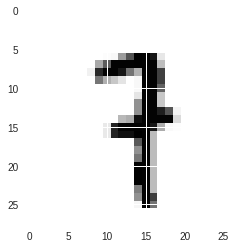

In [42]:
def getData(filePath, numData=-1):
    # Open file
    data_file = open(filePath, 'r')
    # Read lines
    data = data_file.readlines()
    # Close file
    data_file.close()

    # numData is the number of samples in the dataset
    numData = len(data) if numData == -1 else numData
    
    # Zeroise the input vector: numData x 784
    x = np.zeros((numData, 784))[0 : numData]
    # Zeroise the target vector: numData x 10
    t = np.zeros((numData, 10))[0 : numData]

    # For each sample in the dataset
    for i in range(numData):
        # Split by ','
        item = data[i].split(',')
        # Scale the inputs (item[1:]) by 255. They need to fit in the [0, 1] range
        item_x = (np.asfarray(item[1:]) / 255.0)
        x[i] = item_x
        item_t = int(item[0])
        t[i, item_t] = 1
    return x, t

# Get the train data
train_x, train_t = getData("mnist_train.csv")

# Same for the test data
val_x, val_t = getData("mnist_test.csv")

# Get an idea about how things look like in the dataset
print(train_x.shape, train_t.shape)
print(val_x.shape, val_t.shape)

# We'll just plot somthing for the fun of it
randomIndex = np.random.randint(0, len(train_x))
image_array = train_x[randomIndex].reshape((28, 28))
plot.imshow(image_array, cmap='Greys', interpolation=None)


### 2. Structura Rețelei

Problema recunoașterii cifrelor scrise de mână este o provocare destul de bună cu care să testăm puterea unei rețele neurale. Asta pentru că deja vorbim de a recunoaște ce conține o imagine, cât și despre fuzzyness. Nu este foarte clar cum am putea rezolva problema asta cu un set de reguli dat sau în orice alt fel cu metode computaționale.

    2.1. Definim funcțiile de activare & adiacentele:
         2.1.1. sigmoida - va trebui să o găsiți voi printre funcționalitățile oferite de scipy.special.
         2.1.2. derivata sigmoidei
         2.1.3. softmax - aici este necesară o implementare manuală, care lucrează pe batches.
         
    2.2. Inițializăm rețeaua: stabilim o formă pentru aceasta:
         2.2.1. număr de neuroni pe stratul de intrare (no_input), ascuns (no_hidden) și de ieșire (no_output)
         2.2.2. matricea de ponderi o determinăm dintr-o distribuție normală cu media aproape zero și std dev = 0.5. 
                Hint: numpy.random.normal.
                În cazul nostru vorbim despre două matrice de ponderi: 
                 W1 - pentru legăturile dintre stratul de intrare și cel ascuns și 
                 W2 - pentru legăturile dintre stratul ascuns și cel de ieșire.
         2.2.3. Fiecare matrice de ponderi va avea la rândul ei o matrice de gradienţi, care vor fi modificaţi în timpul antrenării. Trebuie să fim foarte antenți ca atunci când ponderile (W1, W2) se modifică, gradienţii se resetează la 0, altfel riscăm să creştem la fiecare pas valorile acestora şi să pierdem controlul asupra reţelei.

----------------------------------------------------------------------------------------------------------------------
    O sumarizare a funcţionării reţelei este următoarea:
    I: (MB, 786)
    W1: (786, 100)
    W2: (100, 10)

    y1 = IxW1 : (MB, 786) x (786, 100) => (MB, 100)
    a1 = sigmoid(y1) : (MB, 100)

    y2 = a1xW2 : (MB, 100) x (100, 10) = (MB, 10)
    a2 = softmax(y2) : (MB, 10)

    E = NLL(a2, T) : (MB, 1) (This is called negative log likelihood or (multi class) cross entropy loss)
----------------------------------------------------------------------------------------------------------------------

    2.3. Forward:
         2.3.1. y1 = I * W1
         2.3.2. a1 = sigmoid(y1)
         2.3.3. y2 = a1 * W2
         2.3.4. a2 = softmax(y2)
         2.3.5. E = NLL(a2, T)

    2.4. Backward:
         2.4.1. dE/da2 = can be skipped
         2.4.2. dE/dy2 = dE/da2 * da2/dy2
                       = NLL'(a2, T) * softmax'(y2) (here we skip demonstration for this)
                       = (a2 - T) : (MB, 10)
         2.4.3. dE/dW2 = dE/dy2 * dy2/dW2 : (MB, 10) x (MB, 100) => (100, 10)
                       = (a2 - T) * a1
         2.4.4. dE/da1 = dE/dy2 * dy2/da1 : (MB, 10) x (100, 10) => (MB, 100)
                       = (a2 - T) * W2
         2.4.5. dE/dy1 = dE/da1 * da1/dy1 : (MB, 100) x (MB, 100) => (MB, 100)
                       = (a2 - T) * W2 * sigmoid'(y1)
                       = (a2 - T) * W2 * y1 * (1 - y1)
         2.4.6. dE/dW1 = dE/dy1 * dy1/dW1 : (MB, 100) x (786, 100) => (786, 100) 
                       = (a2 - T) * W2 * y1 * (1 - y1) * I

    2.5. Testăm rețeaua. Treaba asta se reduce la o propagare înainte a input-urilor folosind ultimul checkpoint sau cel mai bun checkpoint.     

In [0]:
# 2.1. Activation functions

def sigmoid(x):
    # 2.1.1. Implement the sigmoid function
    # Hint scipy.special function
    return scipy.special.expit(x)

def grad_sigmoid(y):
    # 2.1.2. Implement the derivative of the sigmoid function.
    # We have multiple ways to compute this, some more efficient than others.
    # A recomandation is to clip this value to some fixed interval, [-50, 50] for example, 
    # so our network doesn't diverge.
    # Hint: https://math.stackexchange.com/questions/78575/derivative-of-sigmoid-function-sigma-x-frac11e-x
    grad = y * (1 - y)
    return np.clip(grad, -50, 50)

def softmax(x):
    # 2.1.3. Implement softmax.
    # This needs to be batched, so careful with axes. 
    # Basically, we'll get a matrix of shape: (MB, 10), and we'd like to apply the operator to each line 
    # independently (not the entire matrix). We offer a few fixes for numerical stability.
    # Apply softmax on this new input.
    x_new = x - np.max(x, axis=1, keepdims=True)
    x_new = np.clip(x_new, -200, np.inf)
    exp_inputs = np.exp(x_new)
    y = exp_inputs / np.sum(exp_inputs, axis=1, keepdims=True)
    return y

class NeuralNetwork:
    def __init__(self, no_input, no_hidden, no_output):
        
        # 2.2. Initialize the weights
        
        # 2.2.1. Set number of nodes in each layer
        self.no_input = no_input
        self.no_hidden = no_hidden
        self.no_output = no_output
        
        # 2.2.2. Matrices of link weights (b/w input and hidden layer and b/w hidden and output layer)
        # Hint: np.random.randn
        self.W1 = np.random.randn(self.no_input, self.no_hidden)
        self.W2 = np.random.randn(self.no_hidden, self.no_output)

        # 2.2.3. Matrices for gradients of each weight.
        self.dW1 = np.zeros((self.no_input, self.no_hidden))
        self.dW2 = np.zeros((self.no_hidden, self.no_output))

    def forward_pass(self, inputs):
        # 2.3. The forward pass: from the input layer to the outputs.

        # 2.3.1. Compute the inputs of the hidden layer: X_hidden = W1 * I
        # HINT: np.dot
        #       (1, 784) x (784, 100) = (1, 100)
        y1 = np.dot(inputs, self.W1)
        
        # 2.3.2. Non-linearity (sigmoid) for the intermediate outputs
        a1 = sigmoid(y1)

        # 2.3.3. Compute the inputs in the hidden layer
        # HINT: a1 * W2
        y2 = np.dot(a1, self.W2)
        
        # 2.3.4. Compute the outputs (probabilities)
        a2 = softmax(y2)

        return inputs, y1, a1, y2, a2

    def loss(self, outputs, targets):
        T = targets
        
        # 2.3.5. Compute the loss (1 number) using cross entropy
        # Hint: https://stats.stackexchange.com/questions/260505/machine-learning-should-i-use-a-categorical-cross-entropy-or-binary-cross-entro :)
        numItems = T.shape[0]
        E = T * np.log(outputs[-1] + 1e-7)
        E = -np.mean(np.sum(E, axis=1))
        return E        

    def backward(self, outputs, targets):
        # 2.4. Backpropagation
        
        I, y1, a1, y2, a2 = outputs
        T = targets
        E = self.loss(outputs, targets)
        
        # 2.4.1. Skipped

        # 2.4.2. Compute dE/dy2, which is the derivative of the last layer
        # dE/dy2 = dE/da2 * da2/dy2 = deriv(NLL) * deriv(softmax) = (T - O)
        dEdy2 = (a2 - T)

        # 2.4.3. Compute dE/dW2 and accumulate gradients for this layer
        # dE/dW2 = dE/dy2 * dy2/dW2 = (T - a2) * a1
        # (MB, 10) x (MB, 100) => (10, MB) x (MB, 100) => (10, 100) => (100, 10)
        # dEdW2 = (T - a2)
        dEdW2 = np.dot(dEdy2.T, a1).T
        self.dW2 += dEdW2 / len(targets)

        # 2.4.4. Compute dE/da1, which is the derivative of the first layer
        # dE/da1 = dE/dy2 * dy2/da1
        dEda1 = np.dot(dEdy2, self.W2.T)

        # 2.4.5. Compute dE/dy1 = dE/da1 * da1/dy1
        # da1/dy1 = sigmoid'(y1) = y1 * (1 - y1)
        dEdy1 = dEda1 * grad_sigmoid(a1)

        # 2.4.6. Compute dE/dw1 = dE/dy1 * dy1/dw1
        # dy1/dw1 = I
        # Shapes: (1, 100) x (1, 784) => (100, 1) x (1, 784) => (100, 784) => (784, 100)
        dEdw1 = np.dot(dEdy1.T, I).T
        self.dW1 += dEdw1 / len(targets)

        return E

    def optimize(self, lr, debug):
        self.W1 -= lr * self.dW1
        self.W2 -= lr * self.dW2
        self.dW1 *= 0
        self.dW2 *= 0

    def evaluate(self, x, t):
        # 2.5. Compute the performance of the network
        correct = 0
        loss = 0
        
        # 2.5.1. For each sample in the test set
        for i in range(len(x)):
            # inputs
            inputs = np.expand_dims(x[i], axis=0)
            # targets
            targets = np.expand_dims(t[i], axis=0)
            # compute the outputs (forward pass)
            outputs = self.forward_pass(inputs)
            
            # compute the loss = last loss scaled with 0.999 + current loss
            loss = loss * 0.999 + self.loss(outputs, targets)
            
            indexOutput = np.argmax(outputs[-1], axis=1)
            indexTarget = np.argmax(targets, axis=1)
            
            # increment the number of correct guesses (output is equal to target)
            correct += np.sum((indexOutput == indexTarget))

        # 2.5.2. Compute the accuracy of the network: how many are correct from the total of predictions 
        #        (*100 as we want a percentage)
        accuracy = correct / len(x) * 100
        
        # 2.5.3. Ajust the loss 
        loss /= len(x)
        
        return loss, accuracy

## 3. Construim și Antrenăm Rețeaua


Câteva considerații de luat în seamă despre rețea pot fi văzute mai jos.

**Input** 
    - 784 neuroni. 
    De ce? 
    Atâția pixeli am de fapt în imaginile care vin ca input. 
    Fiecare neuron este un pixel din imaginea de intrare.

**Hidden**
    - 100 neuroni. 
    De ce nu mai mulți decât pe stratul de intrare? 
    Pentru că vrem ca rețeaua să găsească niște pattern-uri în input care pot fi exprimate 
    într-o formă mai mică decât input-ul în sine. 
    Vrem un rezumat al input-ului. 
    Ca să obținem asta, obligăm rețeaua să o facă prin micșorarea numărului de neuroni de pe stratul ascuns.
    - adevărul e că alegerea celor 100 de neuroni nu este una foarte științifică. E mai degrabă ceva empiric și de compromis, cumva bazat și pe faptul că la ieșire avem 10 noduri.
    - nu există o rețetă după care să alegem câte noduri avem pe stratul ascuns. În general este bine să cunoaștem în profunzime problema cu care avem de-a face. Pe urmă mai este și experiența. Cu cât avansezi în domeniul acesta, îți va veni mai ușor să estimezi cât mai aproape de ideal acel număr.
    
**Output layer**
    - Ce vrem să primim ca răspuns? 
    Vrem ca rețeaua să ne zică ce cifră avem în imagine. 
    Prin urmare este de ajuns să returneze un număr de la 0 la 9. 
    Cu alte cuvinte, pe ultimul strat vom avea 10 neuroni, 
    fiecare fiind responsabil cu a ne spune ce probabilitate are o cifră dat fiind input-ul. 

    Deeeci transformă label-ul în vector de 10 elemente, cu 1 pe poziția corespunzătoare cifrei din imagine.
    
    
    3. Antrenarea are următorii pași simpli:
        3.1. Se stabileşte un număr de epoci şi o dimensiune a batch-urilor ce sunt propagate la fiecare pas.
        3.2. Se aplică pasul de forward pentru batch-ul respectiv (de la stânga la dreapta în reţea)
        3.3. Se calculează eroarea pentru batch-ul respectiv (un singur număr)
        3.4. Se aplică pasul de backward pentru batch-ul respectiv plecând de la eroarea calculată (de la dreapta
             la stânga) şi se acumulează gradienţii pentru parametrii adaptivi (dW1, dW2)
        3.5. Folosind algoritmul SGD, se updatează matricile de parametrii (W1, W2) după regula:
             Wi[t+1] = Wi[t] - lr * dWi[t]
        3.6. Se restează gradienţii pentru ca la următorul batch să nu se cumuleze: dWi *= 0
        3.7. La finalul fiecărei epoci, se face un pas de forward pentru setul de validare, se calculează eroarea şi este afişată pentru a vedea dacă reţeaua învaţă.
        3.8. Opţional, se salvează doar reţeaua cu cel mai bun loss (sau acurateţe) pe setul de validare.

        O euristică ce poate fi ţinută minte în timpul implementării este următoarea: Dacă o anumită intrare are un shape, spre exemplu W1:(100, 10), atunci şi gradientul său va avea acelaşi shape: dW1:(100, 10).

        De asemenea, implementarea foloseşte batch size-ul pe prima dimensiune. I:(MB, 28*28), y1:(MB, 100) etc. În schimb, matricile de weights-uri sunt independente de batch size, deci trebuie făcută o medie la calcularea gradienţilor (altfel efectiv mărim learning rate-ul artificial şi putem diverge antrenarea)

        Eroarea, fiind de asemenea un singur număr se calculează ca o medie a batch-ului (grijă la dimensiuni).
        a2:(MB, 10), T:(MB, 10), E:(MB, 10) -> (MB, ) -> (1, )

In [0]:
def build_nn(no_input, no_hidden, no_output):
    return NeuralNetwork(no_input=no_input, no_hidden=no_hidden, no_output=no_output)

def build_and_train_nn(no_input, no_hidden, no_output, lr, num_train_data, epochs = 1, printMsg = False):
    return train_nn(build_nn(no_input, no_hidden, no_output), lr, num_train_data, epochs, printMsg)

def train_nn(nn, lr, num_train_data, epochs=1, printMsg = False):
    assert epochs > 0
    
    train_x, train_t = getData("mnist_train.csv", num_train_data)
    val_x, val_t = getData("mnist_test.csv")
    
    # 3.1. Epochs, batch size and number of steps
    numEpochs = 20
    MB = 20
    numSteps = len(train_x) // MB + (len(train_x) % MB != 0)

    print("Training a network using %d train images, batch size %d for %d epoch%s." \
          % (num_train_data, MB, epochs, "s" if epochs > 1 else ""))
    
    for epoch in range(epochs):
        # Train: use all the samples in the dataset.
        for i in range(numSteps):
            # 3.2. Forward
            # 3.2.1. Get the batch (inputs and targets): each time get the next MB samples
            inputs = train_x[i * MB : min((i + 1) * MB, len(train_x))]
            targets = train_t[i * MB : min((i + 1) * MB, len(train_t))]

            # 3.2.2. Propagate the inputs through the network
            out = nn.forward_pass(inputs)
            
            # 3.3. & 3.4. & 3.5. Compute the loss
            loss = nn.backward(out, targets)
            
            # Print at each 100 steps
            if printMsg and i % 100 == 0:
                print("Epoch %d/%d. Iteration %d/%d. Loss: %2.2f" % (epoch + 1, numEpochs, i, numSteps, loss), end="\r")
            
            # 3.6. Optimize
            nn.optimize(lr=0.01, debug=(i % 100 == 0))
        
        # 3.7. Validation
        loss, acc = nn.evaluate(val_x, val_t)
        
        if printMsg:
            print("Epoch %d/%d. Val loss: %2.2f. Val acc: %2.2f" % (epoch + 1, numEpochs, loss, acc))
            
    return nn

## Experimentul 1

### Antrenăm pe 100 exemple, cu 100 de noduri ascunse și learning rate 0.2

O observație pe care o vom face aici este că avem o acuratețe extrem de mică. Dezamăgitoare.

De ce? 
Gândiți-vă la complexitatea task-ului pe care îl are de făcut rețeaua. 
Iar noi îi arătăm doar 100 de imagini apoi avem pretenția să fie capabilă să clasifice corect alte imagini pe care nu le-a mai văzut până acum.

Dar rețeaua asta are de diferențiat între 10 clase diferite (cifrele 0-9). 
Deci în setul de training noi avem maxim câte 10 exemple cu fiecare cifre. 
Gândiți-vă cât variază curbele și liniile pentru fiecare nou exemplu de cifră scrisă de mână. 
Rețeaua abia dacă a apucat să-și schițeze câte ceva despre fiecare cifră în timpul antrenamentului. 
E normală să greșească așa mult.

In [45]:
# Set the number of neurons for the input, hidden and output layer.
no_input = 784
no_hidden = 100
no_output = 10

# Learning rate tells how fast we want the network to learn.
lr = 0.2

# Buid and train
nn = build_and_train_nn(no_input, no_hidden, no_output, lr, 100)

loss, acc = nn.evaluate(val_x, val_t)
print("Val loss: %2.2f. Val acc: %2.2f" % (loss, acc))

Training a network using 100 train images, batch size 20 for 1 epoch.
Val loss: 0.92. Val acc: 5.02


## Experimentul 2

### Antrenăm pe tot setul de date

Haideți să vedem ce se întâmplă dacă folosim tot setul de date (60.000 de exemple) pentru antrenare.

O să observați o acuratețe de peste 60% până la 78%.
De ce credeți că s-a întâmplat asta? Păi pentru simplul fapt că am adăugat mai multe date.
În general asta e soluția care pare cea mai simplă.

In [46]:
# Buid and train
nn = build_and_train_nn(no_input, no_hidden, no_output, lr, 60000)
loss, acc = nn.evaluate(val_x, val_t)
print("Val loss: %2.2f. Val acc: %2.2f" % (loss, acc))

Training a network using 60000 train images, batch size 20 for 1 epoch.
Val loss: 0.12. Val acc: 64.44


## Experimentul 4

### Ne jucăm puțin cu rata de învățare

Haideți să vedem ce se întâmplă când nu avem de unde să mai adăugăm date.
Pentru că... până la urmă datele în sine sunt greu de obținut. 
Un set de date presupune o colectare prealabilă a datelor, pregătirea lor (de exemplu scalare în cazul imaginilor din mai multe surse, vectorizare în cazul cuvintelor, etc.), apoi adnotarea lor (punere de etichete de mână) - un proces destul de dureros de multe ori, etc.

Ce mai putem face?
Să ne jucăm cu learning rate-ul: 
- mărim
- micșorăm.

În felul ăsta vedem pe unde ne situăm din punctul de vedere al dependenței acurateții de learning rate.

Și mai util ar fi să facem mai multe antrenări și teste, cu diverse valori pentru learning rate, să plotăm un grafic și să ne tragem de acolo concluziile.

In [47]:
nn = build_and_train_nn(no_input, no_hidden, no_output, lr * 2, 60000)
loss, acc = nn.evaluate(val_x, val_t)
print("Val loss: %2.2f. Val acc: %2.2f" % (loss, acc))

Training a network using 60000 train images, batch size 20 for 1 epoch.
Val loss: 0.12. Val acc: 63.87


In [48]:
nn = build_and_train_nn(no_input, no_hidden, no_output, lr / 4, 60000)
loss, acc = nn.evaluate(val_x, val_t)
print("Val loss: %2.2f. Val acc: %2.2f" % (loss, acc))

Training a network using 60000 train images, batch size 20 for 1 epoch.
Val loss: 0.12. Val acc: 63.30


## Experimentul 5

### Rulat antrenare de mai multe ori

Să zicem.. de 7 ori. Va trebui să așteptăm ceva dar o să merite :)

De ce facem asta?
Dacă facem gradient descent de mai multe ori, le dăm ocazia ponderilor să se rafineze mai mult. 
Aplicând gradient descent de mai multe ori dăm mai multe șanse de atingere a valorilor optime pentru acestea.

O chestie pe care o vom observa aici este că dacă explorăm timp de mai multe epoci metoda gradient descent, o să ne permitem o rată de învățare mai mică.

In [49]:
nn = build_and_train_nn(no_input, no_hidden, no_output, lr, 60000, epochs=7)
loss, acc = nn.evaluate(val_x, val_t)
print("Val loss: %2.2f. Val acc: %2.2f" % (loss, acc))

Training a network using 60000 train images, batch size 20 for 7 epochs.
Val loss: 0.05. Val acc: 84.83


## Experimentul 6

### Schimbăm Arhitectura Rețelei

Ce ar mai fi de schimbat?
În principiu nu prea putem umbla la stratul de intrare/ieșire din moment ce numărul de neuroni de pe acestea se mapează pe structura datelor de intrare/ieșire.

Ar mai rămâne layer-ul ascuns. Aici se întâmplă de fapt învățarea. 
Dacă privim din avion... aici ajunge input-ul nostru să devină ce vedem la ieșire. 
De fapt mă refer la ponderile de pe conexiunile de dinainte și după stratul de ieșire. 
Dar you get the point :)

De ce nu e ok să avem mai puțin de 100 noduri?
Becoz **learning capacity**. 
Pur și simplu nu avem cum să înghesuim atâta informație în atât de puțini neuroni.

Putem seta la 200 numărul de hidden nodes.

Nu uitați că timpul de rulare este direct proporțional cu acest număr. 
Deci trebuie să luăm și asta în calcul când decidem numărul de hidden nodes. 
Oricum, dacă facem un grafic al felului cum evoluează acuratețea odată cu creșterea numărului de neuroni de pe stratul de ieșire o să observăm că la un moment dat îmbunătățirile nu mai sunt semnificative indiferent cât am crește acest număr. 
Cu alte cuvinte, există o plafonare acolo.

In [50]:
no_hidden = 200
nn2 = build_and_train_nn(no_input, no_hidden, no_output, 0.05, 60000, epochs=20, printMsg=True)
loss, acc = nn2.evaluate(val_x, val_t)
print("Val loss: %2.2f. Val acc: %2.2f" % (loss, acc))

Training a network using 60000 train images, batch size 20 for 20 epochs.
Epoch 1/20. Val loss: 0.14. Val acc: 68.78
Epoch 2/20. Val loss: 0.09. Val acc: 77.02
Epoch 3/20. Val loss: 0.08. Val acc: 80.77
Epoch 4/20. Val loss: 0.07. Val acc: 82.88
Epoch 5/20. Val loss: 0.06. Val acc: 84.05
Epoch 6/20. Val loss: 0.06. Val acc: 84.95
Epoch 7/20. Val loss: 0.05. Val acc: 85.85
Epoch 8/20. Val loss: 0.05. Val acc: 86.53
Epoch 9/20. Val loss: 0.05. Val acc: 87.15
Epoch 10/20. Val loss: 0.05. Val acc: 87.51
Epoch 11/20. Val loss: 0.04. Val acc: 87.86
Epoch 12/20. Val loss: 0.04. Val acc: 88.09
Epoch 13/20. Val loss: 0.04. Val acc: 88.37
Epoch 14/20. Val loss: 0.04. Val acc: 88.66
Epoch 15/20. Val loss: 0.04. Val acc: 88.87
Epoch 16/20. Val loss: 0.04. Val acc: 89.18
Epoch 17/20. Val loss: 0.04. Val acc: 89.41
Epoch 18/20. Val loss: 0.04. Val acc: 89.59
Epoch 19/20. Val loss: 0.03. Val acc: 89.77
Epoch 20/20. Val loss: 0.03. Val acc: 89.84
Val loss: 0.03. Val acc: 89.84


## Bonus 1

### Schimbare non-linearitate din sigmoid in ReLU
Hint: https://stats.stackexchange.com/questions/226923/why-do-we-use-relu-in-neural-networks-and-how-do-we-use-it


In [94]:
def relu(x):
    return x * (x > 0)

def grad_relu(x):
    return x > 0

class NeuralNetworkReLU(NeuralNetwork):
    def forward_pass(self, inputs):
        # 2.3. The forward pass: from the input layer to the outputs.

        y1 = np.dot(inputs, self.W1)
        # Change from sigmoid to relu
        a1 = relu(y1)

        y2 = np.dot(a1, self.W2)
        a2 = softmax(y2)

        return inputs, y1, a1, y2, a2      

    def backward(self, outputs, targets):
        # 2.4. Backpropagation
        
        I, y1, a1, y2, a2 = outputs
        T = targets
        E = self.loss(outputs, targets)
        
        dEdy2 = (a2 - T)
        dEdW2 = np.dot(dEdy2.T, a1).T
        self.dW2 += dEdW2 / len(targets)
        dEda1 = np.dot(dEdy2, self.W2.T)
        # Change from sigmoid's gradient to relu
        # The gradient should be a mask of inputs that are positive, so we only update the
        #  weights to these value.
        dEdy1 = dEda1 * grad_relu(y1)
        dEdw1 = np.dot(dEdy1.T, I).T
        self.dW1 += dEdw1 / len(targets)

        return E   

nn_relu = NeuralNetworkReLU(784, 100, 10)
nn_relu = train_nn(nn_relu, 0.05, 60000, epochs=20, printMsg=True)
loss, acc = nn_relu.evaluate(val_x, val_t)
print("Val loss: %2.2f. Val acc: %2.2f" % (loss, acc))

Training a network using 60000 train images, batch size 20 for 20 epochs.
Epoch 1/20. Val loss: 0.12. Val acc: 85.93
Epoch 2/20. Val loss: 0.09. Val acc: 87.37
Epoch 3/20. Val loss: 0.08. Val acc: 88.63
Epoch 4/20. Val loss: 0.07. Val acc: 89.00
Epoch 5/20. Val loss: 0.06. Val acc: 89.18
Epoch 6/20. Val loss: 0.06. Val acc: 89.43
Epoch 7/20. Val loss: 0.05. Val acc: 89.62
Epoch 8/20. Val loss: 0.05. Val acc: 89.74
Epoch 9/20. Val loss: 0.05. Val acc: 89.96
Epoch 10/20. Val loss: 0.04. Val acc: 90.12
Epoch 11/20. Val loss: 0.04. Val acc: 90.35
Epoch 12/20. Val loss: 0.04. Val acc: 90.47
Epoch 13/20. Val loss: 0.04. Val acc: 90.72
Epoch 14/20. Val loss: 0.03. Val acc: 90.93
Epoch 15/20. Val loss: 0.03. Val acc: 91.04
Epoch 16/20. Val loss: 0.03. Val acc: 91.19
Epoch 17/20. Val loss: 0.03. Val acc: 91.34
Epoch 18/20. Val loss: 0.03. Val acc: 91.57
Epoch 19/20. Val loss: 0.03. Val acc: 91.67
Epoch 20/20. Val loss: 0.03. Val acc: 91.75
Val loss: 0.03. Val acc: 91.75


## Bonus 2

### Adăugare un nou strat intermediar. Noua arhitectura: 768 -> 300 -> 100 -> 10

In [0]:
class NeuralNetwork2Hidden(NeuralNetwork):
    def __init__(self, no_input, no_hidden1, no_hidden2, no_output):
        # Define 3 parameter matrices and 3 gradient matrices (W1, W2, W3, dW1, dW2, dW3)
        self.W1 = np.random.randn(no_input, no_hidden1)
        self.W2 = np.random.randn(no_hidden1, no_hidden2)
        self.W3 = np.random.randn(no_hidden2, no_output)

        # 2.2.3. Matrices for gradients of each weight.
        self.dW1 = np.zeros((no_input, no_hidden1))
        self.dW2 = np.zeros((no_hidden1, no_hidden2))
        self.dW3 = np.zeros((no_hidden2, no_output))
    
    def forward_pass(self, x):
        # Compute a1 = relu(IxW1)
        y1 = np.dot(x, self.W1)
        a1 = sigmoid(y1)

        # Compute a2 = sigmoid(a1xW2)
        y2 = np.dot(a1, self.W2)
        a2 = relu(y2)
        
        # Compute a3 = softmax(a2xW3)
        y3 = np.dot(a2, self.W3)
        a3 = softmax(y3)

        return x, y1, a1, y2, a2, y3, a3
    
    def backward(self, outputs, targets):      
        I, y1, a1, y2, a2, y3, a3 = outputs
        T = targets
        E = self.loss(outputs, targets)
        
        # This should be similar as before (1 hidden layer), but we need new formulas because
        #  the network is deeper. 
        # Compute dE/dy3, dEdW3 (skip dE/da3 as before, because using softmax + NLL)
        dEdy3 = (a3 - T)
        dEdW3 = np.dot(dEdy3.T, a2).T
        # Accumulate (batched) gradients in dW3
        self.dW3 += dEdW3 / len(targets)

        # Compute dE/da2, dE/dy2, dE/dw2
        dEda2 = np.dot(dEdy3, self.W3.T)
        dEdy2 = dEda2 * grad_relu(y2)
        dEdw2 = np.dot(dEdy2.T, a1).T
        # Accumulate (batched) gradients in dW2
        self.dW2 += dEdw2 / len(targets)
        
        # Compute dE/da1, dE/dw1, dEdw1
        dEda1 = np.dot(dEdy2, self.W2.T)
        dEdy1 = dEda1 * grad_sigmoid(a1)
        dEdw1 = np.dot(dEdy1.T, I).T
         # Accumulate (batched) gradients in dW1
        self.dW1 += dEdw1 / len(targets)

        return E   

    def optimize(self, lr, debug):
        # Update all 3 matrices now
        self.W1 -= lr * self.dW1
        self.W2 -= lr * self.dW2
        self.W3 -= lr * self.dW3
        self.dW1 *= 0
        self.dW2 *= 0
        self.dW3 *= 0
    
nn_2hidden = NeuralNetwork2Hidden(784, 300, 100, 10)
nn_2hidden = train_nn(nn_2hidden, 0.05, 60000, epochs=20, printMsg=True)
loss, acc = nn_2hidden.evaluate(val_x, val_t)
print("Val loss: %2.2f. Val acc: %2.2f" % (loss, acc))

Training a network using 60000 train images, batch size 20 for 20 epochs.
Epoch 1/20. Val loss: 0.12. Val acc: 79.274
Epoch 2/20. Val loss: 0.07. Val acc: 79.758
Epoch 3/20. Val loss: 0.06. Val acc: 81.464
Epoch 4/20. Val loss: 0.05. Val acc: 82.903
Epoch 5/20. Val loss: 0.05. Val acc: 84.072
Epoch 6/20. Val loss: 0.04. Val acc: 84.930
Epoch 7/20. Val loss: 0.04. Val acc: 85.589
Epoch 8/20. Val loss: 0.04. Val acc: 86.328
Epoch 9/20. Val loss: 0.04. Val acc: 86.817
Epoch 10/20. Val loss: 0.04. Val acc: 87.367
Epoch 11/20. Val loss: 0.04. Val acc: 87.717
Epoch 12/20. Val loss: 0.03. Val acc: 88.086
Epoch 13/20. Val loss: 0.03. Val acc: 88.476
Epoch 14/20. Val loss: 0.03. Val acc: 88.736
Epoch 15/20. Val loss: 0.03. Val acc: 88.946
Epoch 16/20. Val loss: 0.03. Val acc: 89.066
Epoch 17/20. Val loss: 0.03. Val acc: 89.286
Epoch 18/20. Val loss: 0.03. Val acc: 89.565
Epoch 19/20. Val loss: 0.03. Val acc: 89.645
Epoch 20/20. Val loss: 0.03. Val acc: 89.794
Val loss: 0.03. Val acc: 89.79


## Bonus 3

Testăm pe exemple create de noi în paint :).
Aveţi grijă să fie de dimensiunea (28, 28) !

Saving my_digit.png to my_digit.png
[[0.    0.997 0.001 0.001 0.    0.    0.    0.    0.    0.   ]]
1


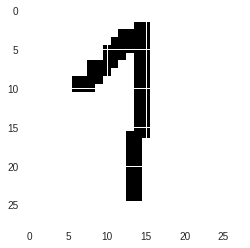

In [99]:
from google.colab import files
from scipy import misc

!rm my_digit*
uploaded = files.upload()

image = np.array(misc.imread("my_digit.png"))[..., 0]
image = np.float32(image) / 255
plot.imshow(image, cmap='Greys', interpolation=None)

image = image.reshape((1, 28 * 28))
result = nn_relu.forward_pass(image)[-1]

np.set_printoptions(precision=3, suppress=True)
print(result)
print(np.argmax(result))